In [1]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from pmdarima.arima import OCSBTest 
from statsmodels.tsa.arima_model import ARIMA
from arch import arch_model
import seaborn as sns
import yfinance
import warnings
warnings.filterwarnings("ignore")
sns.set()

In [2]:
tickers = ['VOW3.DE', 'PAH3.DE', 'BMW.DE']
raw_data = yfinance.download(tickers = tickers, interval = '1d', group_by = 'ticker')
df = raw_data.copy()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  3 of 3 completed


### Defining Key Dates

In [3]:
# Starting Date
start_date = '2009-04-05'

# First Official Announcement - 49.9%
ann_1 = '2009-12-09'

# Second Official Announcement - 50.1%
ann_2 = '2012-07-05'

# Ending Date
end_date = '2014-01-01'

# Dieselgate
d_gate = '2015-09-20'

### Pre-Processing Data

In [4]:
df['vol'] = df['VOW3.DE'].Close
df['por'] = df['PAH3.DE'].Close
df['bmw'] = df['BMW.DE'].Close

df['ret_vol'] = df['vol'].pct_change(1).mul(100)
df['ret_por'] = df['por'].pct_change(1).mul(100)
df['ret_bmw'] = df['bmw'].pct_change(1).mul(100)

df['sq_vol'] = df.ret_vol.mul(df.ret_vol)
df['sq_por'] = df.ret_por.mul(df.ret_por)
df['sq_bmw'] = df.ret_bmw.mul(df.ret_bmw)

df['q_vol'] = df['VOW3.DE'].Volume
df['q_por'] = df['PAH3.DE'].Volume
df['q_bmw'] = df['BMW.DE'].Volume

In [5]:
df = df.asfreq('b')
df = df.fillna(method = 'bfill')
del df['VOW3.DE']
del df['PAH3.DE']
del df['BMW.DE']

In [6]:
df['vol'][start_date:end_date].plot(figsize=(20,8), color = 'blue')
df['por'][start_date:end_date].plot(color='green')
df['bmw'][start_date:end_date].plot(color='gold')
plt.show()

In [7]:
import matplotlib.pyplot as plt

# 1) First segment
ax = df['vol'].loc[start_date:ann_1] \
         .plot(
             figsize=(20, 8),
             color='#33B8FF',
             legend=False
         )
df['por'].loc[start_date:ann_1].plot(ax=ax, color='#49FF3A', legend=False)
df['bmw'].loc[start_date:ann_1].plot(ax=ax, color='#FEB628', legend=False)

# 2) Second segment
df['vol'].loc[ann_1:ann_2].plot(ax=ax, color='#1E7EB2', legend=False)
df['por'].loc[ann_1:ann_2].plot(ax=ax, color='#2FAB25', legend=False)
df['bmw'].loc[ann_1:ann_2].plot(ax=ax, color='#BA861F', legend=False)

# 3) Third segment — only if there is data
if not df['vol'].loc[ann_2:end_date].empty:
    df['vol'].loc[ann_2:end_date].plot(ax=ax, color='#0E3A52', legend=False)
    df['por'].loc[ann_2:end_date].plot(ax=ax, color='#225414', legend=False)
    df['bmw'].loc[ann_2:end_date].plot(ax=ax, color='#7C5913', legend=False)

# 4) Manual legend & show
ax.legend(['Volkswagen', 'Porsche', 'BMW'], fontsize=12)
ax.set_title('Three‐phase Price Evolution', size=16)
plt.show()

In [8]:
print(df[['vol', 'por', 'bmw']][start_date:ann_1].corr())
print(df[['vol', 'por', 'bmw']][ann_1:ann_2].corr())
print(df[['vol', 'por', 'bmw']][end_date:].corr())

Ticker             vol       por       bmw
Price                                     
Ticker Price                              
vol           1.000000  0.663358  0.842761
por           0.663358  1.000000  0.609504
bmw           0.842761  0.609504  1.000000
Ticker             vol       por       bmw
Price                                     
Ticker Price                              
vol           1.000000  0.742827  0.979594
por           0.742827  1.000000  0.704272
bmw           0.979594  0.704272  1.000000
Ticker             vol       por       bmw
Price                                     
Ticker Price                              
vol           1.000000  0.840263  0.483198
por           0.840263  1.000000  0.216126
bmw           0.483198  0.216126  1.000000


### Best Fitting Models

In [9]:
mod_pr_pre_vol = auto_arima(df.vol[start_date:ann_1], exogenous=df[['por', 'bmw']][start_date:ann_1],
                           m=5, map_p=5, max_q=5)
mod_pr_btn_vol = auto_arima(df.vol[ann_1:ann_2], exogenous=df[['por', 'bmw']][ann_1:ann_2],
                           m=5, map_p=5, max_q=5)
mod_pr_post_vol = auto_arima(df.vol[ann_2:end_date], exogenous=df[['por', 'bmw']][ann_2:end_date],
                           m=5, map_p=5, max_q=5)

In [10]:
mod_pr_pre_vol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  178
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -258.661
Date:                Sat, 26 Apr 2025   AIC                            519.322
Time:                        17:48:20   BIC                            522.498
Sample:                    04-06-2009   HQIC                           520.610
                         - 12-09-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         1.0885      0.061     17.983      0.000       0.970       1.207
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):               232.52
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):               2.10   Skew:                            -0.69
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [11]:
mod_pr_btn_vol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  672
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -1165.689
Date:                Sat, 26 Apr 2025   AIC                           2335.377
Time:                        17:50:00   BIC                           2344.395
Sample:                    12-09-2009   HQIC                          2338.870
                         - 07-05-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0899      0.034      2.645      0.008       0.023       0.156
sigma2         1.8900      0.076     24.998      0.000       1.742       2.038
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                85.28
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               5.54   Skew:                             0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [12]:
mod_pr_post_vol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  390
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -660.173
Date:                Sat, 26 Apr 2025   AIC                           1324.346
Time:                        17:50:13   BIC                           1332.273
Sample:                    07-05-2012   HQIC                          1327.488
                         - 01-01-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0879      0.047      1.861      0.063      -0.005       0.180
sigma2         1.7442      0.091     19.175      0.000       1.566       1.923
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                61.79
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.90   Skew:                            -0.15
Prob(H) (two-sided):                  0.56   Kurtosis:                         4.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Predictions for the Future

AttributeError: 'Legend' object has no attribute 'legendHandles'

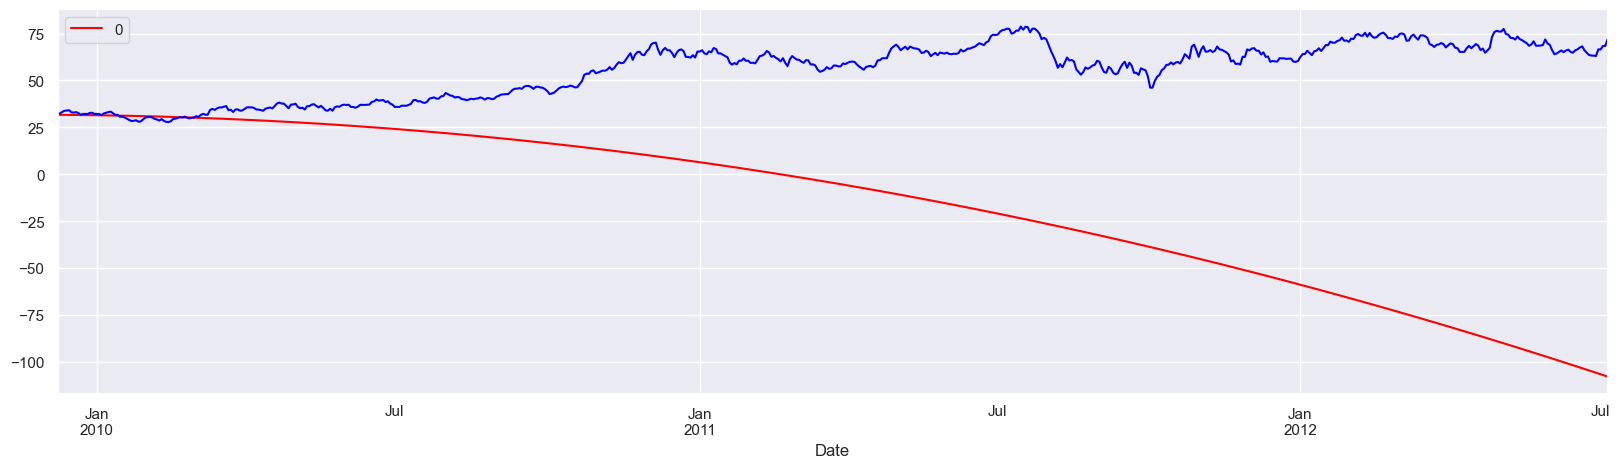

In [13]:
model_auto_pred_pr = auto_arima(df.vol[start_date:ann_1], m=5, max_p = 5, max_q = 5, max_P = 5, max_Q=5, trend ='ct')

df_auto_pred_pr = pd.DataFrame(model_auto_pred_pr.predict(n_periods = len(df[ann_1:ann_2])), index = df[ann_1:ann_2].index)
df_auto_pred_pr[ann_1:ann_2].plot(figsize=(20,5), color="red")

df.vol[ann_1:ann_2].plot(color="blue")
plt.title("VW Predictions (no exog) vs Real Data", size = 24)
plt.show()